In [1]:
import sys
sys.path.append('..')

In [10]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

from datasets.sequence_folders import SequenceFolder
from utils import tensor2array

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
train_set = SequenceFolder(
            '/mnt/datasets/yasin/range-azimuth',
            train=True,
            sequence_length=3,
            skip_frames=10
        )

In [6]:
train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=8, shuffle=True,
        num_workers=4, pin_memory=True)

In [7]:
dataset_iter = iter(train_loader)
tgt_img, ref_imgs = next(dataset_iter)
tgt_img = tgt_img.to(device)
ref_imgs = [img.to(device) for img in ref_imgs]

In [8]:
print(tgt_img.shape)
print(len(ref_imgs))
print(ref_imgs[0].shape)
print(tgt_img.mean(), tgt_img.std())

torch.Size([8, 1, 256, 64])
2
torch.Size([8, 1, 256, 64])
tensor(119.4595, device='cuda:0') tensor(6.5373, device='cuda:0')


In [50]:
rangeResolutionsInMeter = 0.0977
numRangeBins = 256
num_angle_bins = 64

warper = Warper(rangeResolutionsInMeter, numRangeBins, num_angle_bins, 0)

In [71]:
pose = torch.tensor([0.8, 0, 0, 0,0,0.1745])
print(pose.shape)
pose_batch = pose.repeat(8,1)
print(pose_batch.shape)
pose_batch = pose_batch.to(device)

torch.Size([6])
torch.Size([8, 6])


In [72]:
projected_img, valid_points, theta_tformed, rho_tformed = warper.inverse_warp_fft(ref_imgs[0], pose_batch)

In [73]:
theta_tformed_hw = theta_tformed[0].reshape(64, 256)
print(theta_tformed_hw.shape)
print(theta_tformed_hw)

torch.Size([64, 256])
tensor([[  0.0000, -23.5259, -23.5259,  ..., -23.5259, -23.5259, -23.5259],
        [  0.0000, -22.7154, -22.7154,  ..., -22.7154, -22.7154, -22.7154],
        [  0.0000, -21.9122, -21.9122,  ..., -21.9122, -21.9122, -21.9122],
        ...,
        [  0.0000,  21.1161,  21.1161,  ...,  21.1161,  21.1161,  21.1161],
        [  0.0000,  21.9122,  21.9122,  ...,  21.9122,  21.9122,  21.9122],
        [  0.0000,  22.7154,  22.7154,  ...,  22.7154,  22.7154,  22.7154]],
       device='cuda:0')


In [74]:
rho_tformed_hw = rho_tformed[0].reshape(64, 256)
print(rho_tformed_hw.shape)
print(rho_tformed_hw)

torch.Size([64, 256])
tensor([[ 0.0000,  0.0904,  0.1807,  ..., 22.8625, 22.9528, 23.0432],
        [ 0.0000,  0.0908,  0.1816,  ..., 22.9691, 23.0599, 23.1507],
        [ 0.0000,  0.0912,  0.1824,  ..., 23.0734, 23.1646, 23.2558],
        ...,
        [ 0.0000,  0.0916,  0.1832,  ..., 23.1751, 23.2667, 23.3583],
        [ 0.0000,  0.0912,  0.1824,  ..., 23.0734, 23.1646, 23.2558],
        [ 0.0000,  0.0908,  0.1816,  ..., 22.9691, 23.0599, 23.1507]],
       device='cuda:0')


In [12]:
print(projected_img.shape)

torch.Size([8, 1, 256, 64])


In [75]:
img_tgt = tensor2array(tgt_img[0], colormap='bone')
img_src = tensor2array(projected_img[0], colormap='bone')

In [76]:
img_tgt=img_tgt.transpose(1, 2, 0)
img_src=img_src.transpose(1, 2, 0)

print(img_tgt.shape)
print(img_src.shape)

(256, 64, 4)
(256, 64, 4)


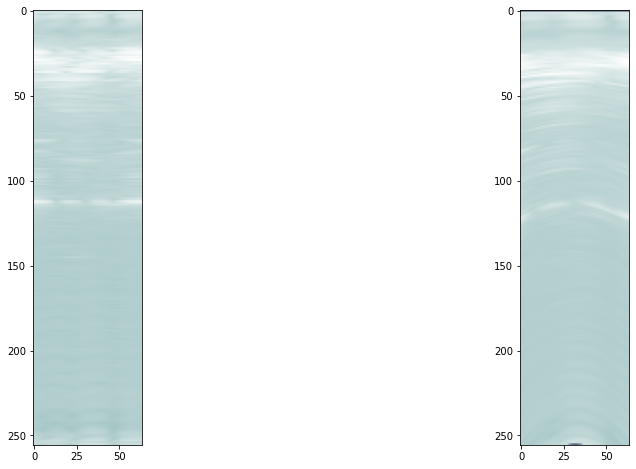

In [77]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img_tgt)
plt.subplot(122)
plt.imshow(img_src)

In [49]:
from __future__ import division
import torch
import torch.nn.functional as F

import conversions as tgm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class Warper(object):
    """Inverse warper class
    """

    # xy_hom = None

    def __init__(self, rangeResolutionsInMeter, numRangeBins, num_angle_bins,
    with_auto_mask, padding_mode='zeros'):
        # RF params
        # rangeResolutionsInMeter = 0.0977
        # # dopplerResolutionMps = 0.0951
        # numRangeBins = 256
        # # numDopplerBins = 128
        # num_angle_bins = 64 # our choice
        self.rangeResolutionsInMeter=rangeResolutionsInMeter
        self.numRangeBins=numRangeBins
        self.num_angle_bins=num_angle_bins
        self.with_auto_mask=with_auto_mask
        self.padding_mode=padding_mode

        azimuths = torch.arange(num_angle_bins)
        azimuths = (azimuths - (num_angle_bins / 2))
        ranges = torch.arange(numRangeBins)
        ranges = ranges*rangeResolutionsInMeter

        az_grid, range_grid = torch.meshgrid(azimuths, ranges)
        x, y = pol2cart(torch.deg2rad(az_grid), range_grid)
        x=torch.flatten(x)
        y=torch.flatten(y)

        xy = torch.vstack((x, y, torch.zeros_like(x)))  # [3,N] Augment with zero z column
        xy = torch.transpose(xy, 0,1) # [N,3]
        self.xy_hom = tgm.convert_points_to_homogeneous(xy).to(device) # [N,4]

    
    def radar2pixel(self, pose_mat):
        """Transform coordinates in the source frame to the target frame.
        Args:
            cam_coords: pixel coordinates defined in the first camera coordinates system -- [B, 4, H, W]
            proj_c2p_rot: rotation matrix of cameras -- [B, 3, 4]
            proj_c2p_tr: translation vectors of cameras -- [B, 3, 1]
        Returns:
            array of [-1,1] coordinates -- [B, 2, H, W]
        """
        # Transform points
        tformed_xy_hom = torch.matmul(pose_mat, torch.transpose(self.xy_hom, 0,1)) # [B,4,N]
        tformed_xy_hom = torch.transpose(tformed_xy_hom, 1,2) # [B,N,4]
        # Convert from homogenous coordinates
        tformed_xy = tgm.convert_points_from_homogeneous(tformed_xy_hom) # [B,N,3]
        # Convert back from cartesian to polar
        theta_tformed_rad, rho_tformed = cart2pol(tformed_xy[:,:,0], tformed_xy[:,:,1]) # [B,N], [B,N]
        theta_tformed = torch.rad2deg(theta_tformed_rad) # [B,N]
        

        # tformed_xy = tformed_xy[:,0:2,:] # Drop augmented z column [B,2,N]
        # Replace 0-valued augmented z column with dB values of source img 
        # tformed_xy[:,2,:] = torch.flatten(img, start_dim=1) # [B,3,N] N points with x,y and db values

        X = theta_tformed # [B,N]
        Y = rho_tformed # [B,N]
        w = self.num_angle_bins
        h = (self.numRangeBins-1)*self.rangeResolutionsInMeter

        # Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1) [B, H*W]
        X_norm = 2*X/w
        Y_norm = 2*Y/h - 1  # Idem [B, H*W]

        pixel_coords = torch.stack([X_norm, Y_norm], dim=2)  # [B, H*W, 2]
        pixel_coords = pixel_coords.reshape(self.b, self.w, self.h, 2)
        pixel_coords = pixel_coords.transpose(1,2)

        return pixel_coords, theta_tformed, rho_tformed
    
    def inverse_warp_fft(self, img, pose, rotation_mode='euler'):
        """
        Inverse warp a source radar frame to the target radar plane.
        H: Number of ADC samples (or Doppler bins)
        W: Number of angle bins
        Args:
            img: the source radar frame image (where to sample pixels) -- [B, H, W]
            pose: 6DoF pose parameters from target to source -- [B, 6]
        Returns:
            projected_img: Source image warped to the target image plane
            valid_points: Boolean array indicating point validity
        """
        check_sizes(img, 'img', 'B1HW')
        check_sizes(pose, 'pose', 'B6')

        self.b, self.c, self.h, self.w = img.size()

        assert self.w == self.num_angle_bins
        assert self.h == self.numRangeBins

        # if (xy_hom is None) or xy_hom.size(1) < 4:
        #     set_radar_grid()

        # Convert 6 DoF pose to 4x4 transformation matrix
        pose_mat = tgm.rtvec_to_pose(pose)  # T*R in homogenous coordinates [B,4,4]
        
        # src_pixel_coords = pixel_coords.reshape(b, h, w, 2)
        src_pixel_coords, theta_tformed, rho_tformed = self.radar2pixel(pose_mat)  # [B,H,W,2]

        projected_img = F.grid_sample(
            img, src_pixel_coords, padding_mode=self.padding_mode)

        # calculate mask values for each tformed_xy coordinates to match the target xy
        valid_points = src_pixel_coords.abs().max(dim=-1)[0] <= 1 # [B,H,W]
        valid_points = torch.unsqueeze(valid_points, 1) # [B,1,H,W]

        return projected_img, valid_points, theta_tformed, rho_tformed

    #TODO: num_scales eklenebilir buraya.
    # decibels loss
    def compute_db_loss(self, tgt_img, ref_imgs, poses, poses_inv):

        db_loss = 0
        projected_imgs = ref_imgs

        for i, (ref_img, pose, pose_inv) in enumerate(zip(ref_imgs, poses, poses_inv)):

            db_loss1, projected_img = self.compute_pairwise_loss(tgt_img, ref_img, pose)
            db_loss2, _ = self.compute_pairwise_loss(ref_img, tgt_img, pose_inv)

            db_loss += (db_loss1 + db_loss2)
            projected_imgs[i] = projected_img

        return db_loss, projected_imgs


    def compute_pairwise_loss(self, tgt_img, ref_img, pose):

        ref_img_warped, valid_mask = self.inverse_warp_fft(ref_img, pose)

        diff_img = (tgt_img - ref_img_warped).abs().clamp(0, 1)

        if self.with_auto_mask == True:
            auto_mask = (diff_img < (tgt_img - ref_img).abs()).float() # [B,1,H,W]
            valid_mask = auto_mask * valid_mask # element-wise # [B,1,H,W]

        # compute all loss
        reconstruction_loss = mean_on_mask(diff_img, valid_mask)

        return reconstruction_loss, ref_img_warped

# compute mean value given a binary mask
def mean_on_mask(diff, valid_mask):
    mask = valid_mask.expand_as(diff)
    if mask.sum() > 10000:
        mean_value = (diff * mask).sum() / mask.sum()
    else:
        mean_value = torch.tensor(0).float().to(device)
    return mean_value




# # TODO: function could be parametrized
# def set_radar_grid():
#     global xy_hom
#     # RF params
#     rangeResolutionsInMeter = 0.0977
#     # dopplerResolutionMps = 0.0951
#     numRangeBins = 256
#     # numDopplerBins = 128
#     num_angle_bins = 64 # our choice

#     azimuths = np.arange(num_angle_bins)
#     azimuths = (azimuths - (num_angle_bins / 2))
#     ranges = np.arange(numRangeBins)
#     ranges *= rangeResolutionsInMeter

#     az_grid, range_grid = torch.meshgrid(azimuths, ranges)
#     x, y = pol2cart(torch.deg2rad(az_grid), range_grid)
#     x=torch.flatten(x)
#     y=torch.flatten(y)

#     xy = torch.vstack((x, y, torch.zeros_like(x)))  # Nx3 Augment with zero z column
#     xy_hom = tgm.convert_points_to_homogeneous(input)  # Nx4



def check_sizes(input, input_name, expected):
    condition = [input.ndimension() == len(expected)]
    for i, size in enumerate(expected):
        if size.isdigit():
            condition.append(input.size(i) == int(size))
    assert(all(condition)), "wrong size for {}, expected {}, got  {}".format(
        input_name, 'x'.join(expected), list(input.size()))



def cart2pol(x, y):
    rho = torch.sqrt(x**2 + y**2)
    phi = torch.atan2(y, x)
    return phi, rho

def pol2cart(phi, rho):
    x = rho * torch.cos(phi)
    y = rho * torch.sin(phi)
    return x, y

In [36]:
azimuths = torch.arange(num_angle_bins)
azimuths = (azimuths - (num_angle_bins / 2))
ranges = torch.arange(numRangeBins)
ranges = ranges*rangeResolutionsInMeter

az_grid, range_grid = torch.meshgrid(azimuths, ranges)

In [37]:
print(az_grid.shape)

torch.Size([64, 256])


# Test FFT reconstruction loss

In [35]:
tgt = tgt_img
src = ref_imgs[0]
# Apply 2D FFT on the last two dimensions, e.g., [H,W] channels.
fft_tgt = torch.fft.rfftn(tgt, s=tgt.shape[-2:], dim=[-2,-1], norm="forward") # [B,C,H,W,2]
fft_src = torch.fft.rfftn(src, s=tgt.shape[-2:], dim=[-2,-1], norm="forward") # [B,C,H,W,2]
# fft_diff = torch.fft.rfftn(tgt-src, s=tgt.shape[-2:], dim=[-2,-1], norm="ortho") # [B,C,H,W,2]


In [36]:
fft_diff_phase = torch.abs(fft_tgt.angle() - fft_src.angle())
print(fft_diff_phase.sum())
print(fft_diff_phase.min())

tensor(119447.0938, device='cuda:0')
tensor(0., device='cuda:0')


In [37]:
fft_diff_amp = torch.abs(fft_tgt.abs() - fft_src.abs())
print(fft_diff_amp.sum())
print(20*torch.log10(fft_diff_amp).sum())
print(fft_diff_amp.min())

tensor(276.8846, device='cuda:0')
tensor(-4531531., device='cuda:0')
tensor(1.0739e-08, device='cuda:0')


In [38]:
fft_tgt.shape

torch.Size([8, 1, 256, 33])